# Minplus algebra experiment

This code attempts to learn the 64D mixture prior
$J(x) = min(\frac{1}{2t\sigma_{1}}||x-\mu_{1}||^{2}, \frac{1}{2\sigma_{2}}||x-\mu_{2}||^{2})$
assuming we have access to training data $\{y_i, S(y_i)\} = min_{x \in \R} \ \{0.5||x-y_i||^{2}_{2} + J(x)\}\}$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_64D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the solution S(y,t) of the Hamilton--Jacobi
    PDE for the minplus algebra example at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        hjsol:  An n-dimensional numpy array of numbers
    '''

    val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
    hjsol = np.minimum(val1,val2)
    return hjsol


def prior_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the initial data of the Hamilton--Jacobi
    PDE for the minplus algebra example.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        prior:  An n-dimensional numpy array of numbers
    '''
        
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/sigma1
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/sigma2
    prior = np.minimum(val1,val2)
    return prior


def cvx_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes 0.5*norm(y)_{2}^{2} - S(y,t) at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        cvx:  An n-dimensional numpy array of numbers
    '''

    cvx = 0.5*pow(euclid_norm(y),2) - hjsol_true(y,mu1,mu2,sigma1,sigma2)
    return cvx


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.subplots()
    plt.plot(xi, x1_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x1_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the convex function")
    plt.xlabel('$x_1$')
    plt.ylabel('Convex functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x2_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the convex function")
    plt.xlabel('$x_2$')
    plt.ylabel('Convex functions (0, $x_2$)')
    plt.legend()

    # Plot cross sections of the prior function
    plt.subplots()
    plt.plot(xi, x1_0_prior_est, "-", label="LPN")
    plt.plot(xi, x1_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the prior function")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_prior_est, "-", label="LPN")
    plt.plot(xi, x2_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the prior function")
    plt.xlabel('$x_2$')
    plt.ylabel('Prior functions (0, $x_2$)')
    plt.legend()




def plot_all(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 64

# Prior parameters
mu1 = np.zeros(dim); mu1[0] = 1.0;  sigma1 = 1.0
mu2 = np.ones(dim)/np.sqrt(dim);    sigma2 = 1.0

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 7553.564453125
iteration 0 loss 3114.09765625


iteration 5000 loss 0.6675642728805542


iteration 10000 loss 0.11761215329170227


iteration 15000 loss 0.05275933817028999


iteration 20000 loss 0.06512177735567093


iteration 25000 loss 0.02478775940835476


iteration 30000 loss 0.016383470967411995


iteration 35000 loss 0.011531482450664043


iteration 40000 loss 0.01038725208491087


iteration 45000 loss 0.008945474401116371


iteration 50000 loss 0.007612095680087805


iteration 55000 loss 0.015695303678512573


iteration 60000 loss 0.0042811729945242405


iteration 65000 loss 0.006961487233638763


iteration 70000 loss 0.10871972143650055


iteration 75000 loss 0.0598902590572834


iteration 80000 loss 0.12535053491592407


iteration 85000 loss 0.09036850184202194


iteration 90000 loss 0.07031024247407913


iteration 95000 loss 0.7585390210151672


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.024073418229818344


iteration 105000 loss 0.000861438806168735


iteration 110000 loss 0.0017568363109603524


iteration 115000 loss 0.0032221144065260887


iteration 120000 loss 0.00020200799917802215


iteration 125000 loss 0.0001401486515533179


iteration 130000 loss 0.00010261090938001871


iteration 135000 loss 7.447322423104197e-05


iteration 140000 loss 5.4022013500798494e-05


iteration 145000 loss 0.00869735050946474


iteration 150000 loss 0.007836511358618736


iteration 155000 loss 2.8798544008168392e-05


iteration 160000 loss 7.007270323811099e-05


iteration 165000 loss 7.29205712559633e-05


iteration 170000 loss 1.6791746020317078e-05


iteration 175000 loss 0.0006860341527499259


iteration 180000 loss 6.484146069851704e-06


iteration 185000 loss 0.0024633712600916624


iteration 190000 loss 8.315659215440974e-05


iteration 195000 loss 3.6468265989242354e-06


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 2.7850062451761914e-06


iteration 205000 loss 2.242454911538516e-06


iteration 210000 loss 1.7121052451329888e-06


iteration 215000 loss 1.321359263783961e-06


iteration 220000 loss 1.8613573047332466e-06


iteration 225000 loss 8.253715577666298e-07


iteration 230000 loss 6.167768447085109e-07


iteration 235000 loss 6.123493108134426e-07


iteration 240000 loss 6.301221446847194e-07


iteration 245000 loss 3.000468495883979e-07


iteration 250000 loss 4.717312549473718e-07


iteration 255000 loss 1.8927384815015103e-07


iteration 260000 loss 1.545635228694664e-07


iteration 265000 loss 1.2441044816569047e-07


iteration 270000 loss 1.1362660501390565e-07


iteration 275000 loss 5.7735062000574544e-05


iteration 280000 loss 7.31812619392258e-08


iteration 285000 loss 6.089950232990304e-08


iteration 290000 loss 5.0180066324401196e-08


iteration 295000 loss 3.1170129659585655e-05


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 3.7009339592941615e-08


iteration 305000 loss 3.387478031413593e-08


iteration 310000 loss 3.083676958226533e-08


iteration 315000 loss 2.6633152572230756e-08


iteration 320000 loss 2.2501128071894527e-08


iteration 325000 loss 2.1262360405671643e-06


iteration 330000 loss 1.8643861565692532e-08


iteration 335000 loss 1.6674885472411916e-08


iteration 340000 loss 1.521019221684128e-08


iteration 345000 loss 1.3446006974504598e-08


iteration 350000 loss 1.2098866797316532e-08


iteration 355000 loss 1.117466119637811e-08


iteration 360000 loss 1.0208112577458905e-08


iteration 365000 loss 9.315653137775826e-09


iteration 370000 loss 8.612927260287506e-09


iteration 375000 loss 7.931141077222037e-09


iteration 380000 loss 4.209845982927618e-08


iteration 385000 loss 6.532180130136567e-09


iteration 390000 loss 6.04515726365662e-09


iteration 395000 loss 1.5339010062120906e-08


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 5.082929188660046e-09


iteration 405000 loss 4.9336983387604505e-09


iteration 410000 loss 4.69485827991889e-09


iteration 415000 loss 4.471813586093276e-09


iteration 420000 loss 4.282969978675055e-09


iteration 425000 loss 4.108277718017916e-09


iteration 430000 loss 3.9107974636465315e-09


iteration 435000 loss 3.7269920483140595e-09


iteration 440000 loss 3.5967906431011443e-09


iteration 445000 loss 3.449389884835341e-09


iteration 450000 loss 3.2877369715578197e-09


iteration 455000 loss 3.1667051203498886e-09


iteration 460000 loss 3.0468432221653075e-09


iteration 465000 loss 2.9489808373028836e-09


iteration 470000 loss 2.8366982096628135e-09


iteration 475000 loss 2.6858228974191434e-09


iteration 480000 loss 2.5670450209958062e-09


iteration 485000 loss 1.7645369609908812e-07


iteration 490000 loss 2.3937851700850388e-09


iteration 495000 loss 2.317612102231692e-09


L2 loss -- Plot

loss -59.93901824951172


loss -235.16448974609375


loss -333.372314453125


loss -419.54901123046875


loss -499.2265930175781


loss -572.0714111328125


loss -637.201416015625


loss -693.680908203125


loss -740.7167358398438


loss -778.072509765625


loss -806.2523193359375


loss -826.34375


loss -839.7551879882812


loss -848.0624389648438


loss -852.8086547851562


loss -855.28955078125


loss -856.456787109375


loss -856.9375


loss -857.1038818359375


loss -857.1495361328125


loss -857.15869140625


loss -857.159912109375


loss -857.159912109375


loss -857.1599731445312


loss -857.1599731445312


loss -857.159912109375


loss -857.1599731445312


loss -857.1599731445312


loss -857.1599731445312


loss -857.159912109375


loss -857.1599731445312


loss -857.1599731445312


loss -857.159912109375


loss -857.159912109375


loss -857.1599731445312


loss -857.1599731445312


loss -857.1599731445312


loss -857.1599731445312


loss -857.159912109375


loss -857.1599731445312


final mse:  2.3455576370068343e-10
max, min: 6.2356687 -7.127014
loss -59.93901824951172


loss -231.40879821777344


loss -328.86334228515625


loss -415.7642517089844


loss -496.66082763671875


loss -571.3424072265625


loss -639.0413818359375


loss -698.8094482421875


loss -749.76171875


loss -791.43359375


loss -824.0280151367188


loss -848.389892578125


loss -865.7457275390625


loss -877.4969482421875


loss -885.038818359375


loss -889.6011962890625


loss -892.1724243164062


loss -893.4962768554688


loss -894.101318359375


loss -894.337158203125


loss -894.4114990234375


loss -894.4291381835938


loss -894.4320678710938


loss -894.432373046875


loss -894.432373046875


loss -894.4322509765625


loss -894.4323120117188


loss -894.432373046875


loss -894.4323120117188


loss -894.432373046875


loss -894.432373046875


loss -894.432373046875


loss -894.432373046875


loss -894.4323120117188


loss -894.4323120117188


loss -894.432373046875


loss -894.4323120117188


loss -894.432373046875


loss -894.4323120117188


loss -894.432373046875


final mse:  2.5563193228883563e-10
max, min: 7.501269 -7.347508


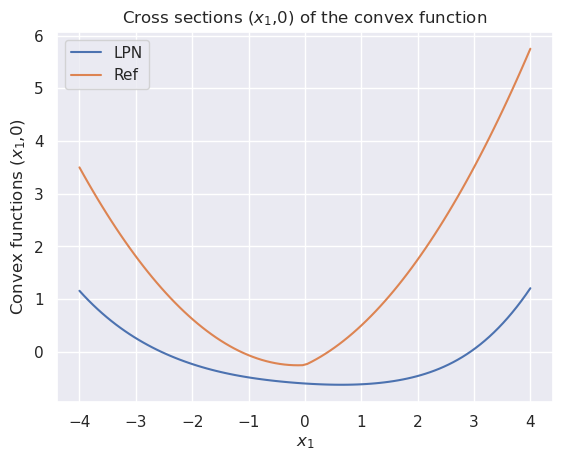

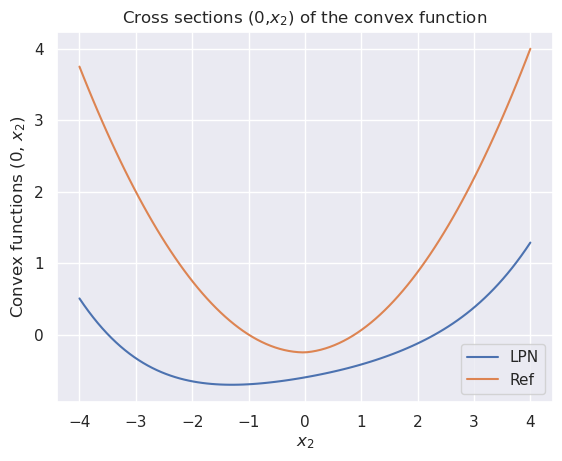

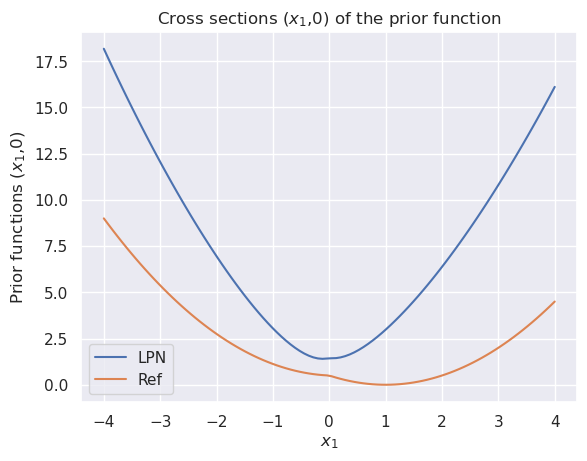

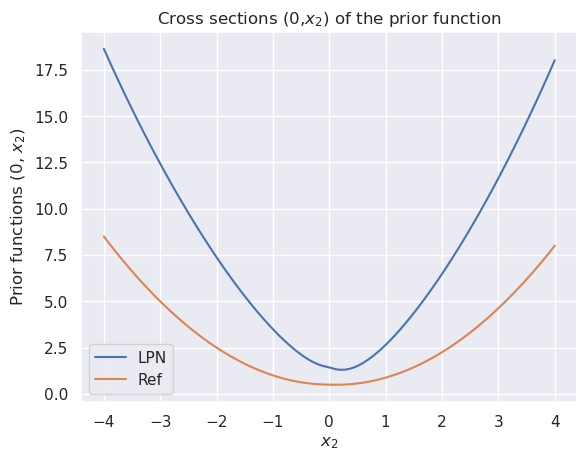

In [7]:
plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN  ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")

Generated G samples: G_samples_tensor shape torch.Size([40000, 1])

--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 4510.12646484375
iteration 0 loss 2163.981201171875


iteration 5000 loss 0.7447054386138916


iteration 10000 loss 0.14473742246627808


iteration 15000 loss 0.08259289711713791


iteration 20000 loss 0.05333608388900757


iteration 25000 loss 0.031012725085020065


iteration 30000 loss 0.027921238914132118


iteration 35000 loss 0.017535464838147163


iteration 40000 loss 0.01470684353262186


iteration 45000 loss 0.019447049126029015


iteration 50000 loss 8.919367790222168


iteration 55000 loss 0.010205532424151897


iteration 60000 loss 0.008075912483036518


iteration 65000 loss 0.006546935997903347


iteration 70000 loss 0.007552268914878368


iteration 75000 loss 0.00629826495423913


iteration 80000 loss 0.005667487159371376


iteration 85000 loss 0.0038967360742390156


iteration 90000 loss 0.003930824808776379


iteration 95000 loss 0.0689404159784317


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.0024853621143847704


iteration 105000 loss 0.001194444135762751


iteration 110000 loss 0.0007304141763597727


iteration 115000 loss 0.0004960444057360291


iteration 120000 loss 0.0003598981420509517


iteration 125000 loss 0.00026246526977047324


iteration 130000 loss 0.00020082987612113357


iteration 135000 loss 0.00015713348693680018


iteration 140000 loss 0.0001188855167129077


iteration 145000 loss 9.643642988521606e-05


iteration 150000 loss 7.301776349777356e-05


iteration 155000 loss 5.964862066321075e-05


iteration 160000 loss 4.6017121348995715e-05


iteration 165000 loss 3.7241628888295963e-05


iteration 170000 loss 3.0097975468379445e-05


iteration 175000 loss 2.3666218112339266e-05


iteration 180000 loss 1.941346999956295e-05


iteration 185000 loss 1.5482906746910885e-05


iteration 190000 loss 1.3743844647251535e-05


iteration 195000 loss 1.0913870937656611e-05


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 9.296203643316403e-06


iteration 205000 loss 7.70930819271598e-06


iteration 210000 loss 6.093521733419038e-06


iteration 215000 loss 4.951998107571853e-06


iteration 220000 loss 4.063872893311782e-06


iteration 225000 loss 3.3051869650080334e-06


iteration 230000 loss 2.756135017989436e-06


iteration 235000 loss 2.2725594135408755e-06


iteration 240000 loss 1.8716018530540168e-06


iteration 245000 loss 1.5443172287632478e-06


iteration 250000 loss 1.3340727491595317e-06


iteration 255000 loss 1.0884139101108303e-06


iteration 260000 loss 9.095409723158809e-07


iteration 265000 loss 0.0011882864637300372


iteration 270000 loss 6.613378786823887e-07


iteration 275000 loss 5.539686753763817e-07


iteration 280000 loss 4.633955654753663e-07


iteration 285000 loss 3.88248821536763e-07


iteration 290000 loss 3.5966985478808056e-07


iteration 295000 loss 3.0179967325238977e-07


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 2.53150943763103e-07


iteration 305000 loss 2.299790935467172e-07


iteration 310000 loss 1.9777637305651297e-07


iteration 315000 loss 1.7317974254638102e-07


iteration 320000 loss 1.516309708904373e-07


iteration 325000 loss 1.335989310291552e-07


iteration 330000 loss 1.1760359086565586e-07


iteration 335000 loss 1.043254727051135e-07


iteration 340000 loss 9.295337122239289e-08


iteration 345000 loss 8.320947841866655e-08


iteration 350000 loss 7.442562832693511e-08


iteration 355000 loss 6.720085821143584e-08


iteration 360000 loss 6.096330196214694e-08


iteration 365000 loss 5.560791294101364e-08


iteration 370000 loss 5.085867016418888e-08


iteration 375000 loss 4.6544158749384223e-08


iteration 380000 loss 4.302927081312191e-08


iteration 385000 loss 3.914391299986164e-08


iteration 390000 loss 3.6064754738163174e-08


iteration 395000 loss 3.3910197316799895e-08


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 3.0914097948198105e-08


iteration 405000 loss 3.0295666419988265e-08


iteration 410000 loss 2.724461367620279e-08


iteration 415000 loss 2.5552999716182967e-08


iteration 420000 loss 1.5601895597683324e-07


iteration 425000 loss 2.23128928666938e-08


iteration 430000 loss 2.087753081525534e-08


iteration 435000 loss 1.9615242763393326e-08


iteration 440000 loss 1.8370089449604166e-08


iteration 445000 loss 1.7379232275516188e-08


iteration 450000 loss 1.6492208487761673e-08


iteration 455000 loss 1.5626893556941468e-08


iteration 460000 loss 1.483705780458422e-08


iteration 465000 loss 1.4145989268854464e-08


iteration 470000 loss 1.3395633935431306e-08


iteration 475000 loss 1.287182094245054e-08


iteration 480000 loss 1.2244100844327477e-08


iteration 485000 loss 1.1818205081226552e-08


iteration 490000 loss 1.1247205833342377e-08


iteration 495000 loss 1.0885852219644221e-08


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


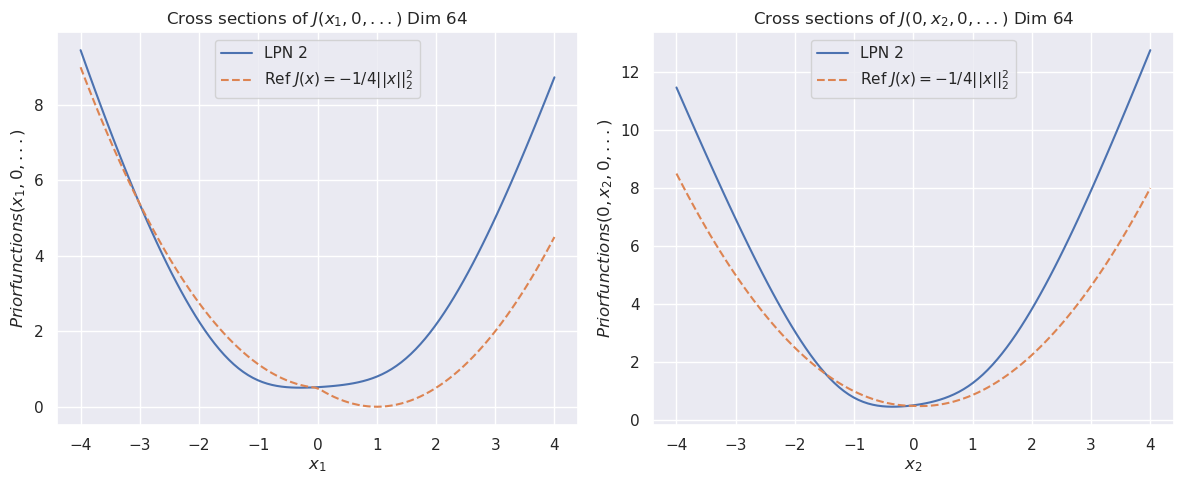

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)

    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)
    else:
        x2_0_J_true = x1_0_J_true
        
    
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2)